In [1]:
%%capture
%cd ..

In [2]:
# Imports
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.constants import white_list

In [3]:
# Some constants values
data_dir: str = "dataset/CS2_38"
cleaned = "dataset/cleaned"
df = pd.DataFrame()
hi = pd.DataFrame()

current = 'Current(A)'
voltage = 'Voltage(V)'
c_index = 'Cycle_Index'
# time = 'Test_Time(s)'
t0_voltage = 3.8
t1_voltage = 4.1999

datasets = {}

In [ ]:
CS2_38_cleaned = pd.DataFrame()

for filename in os.listdir(data_dir):
    xls_file = pd.ExcelFile(os.path.join(data_dir, filename))
    sheet_fnames = [sheet for sheet in xls_file.sheet_names if sheet.startswith('Channel')]

    # print(filename)
    for sheet_fname in sheet_fnames:
        df_temp = pd.read_excel(os.path.join(data_dir, filename), sheet_name=sheet_fname)
        df_temp = df_temp[white_list]
        # Trovare il massimo valore di Cycle_Index in CS2_38_cleaned
        max_combined_cycle_index = CS2_38_cleaned['Cycle_Index'].max() if not CS2_38_cleaned.empty else 0
        print(max_combined_cycle_index)
        # Aggiornare i valori di Cycle_Index nel DataFrame corrente
        df_temp['Cycle_Index'] += max_combined_cycle_index
        print(df_temp['Cycle_Index'])
        # Aggiungere il DataFrame corrente a CS2_38_cleaned
        CS2_38_cleaned = pd.concat([CS2_38_cleaned, df_temp], ignore_index=True)

In [ ]:
CS2_38_cleaned.to_csv(os.path.join(cleaned, 'CS2_38_cleaned.csv'), index=False)

In [4]:
path: str = 'dataset/cleaned/CS2_38_cleaned.csv'
# Carica il DataFrame dal tuo file CSV
df_concat = pd.read_csv(path)
df_concat['Index'] = df_concat.index
max_voltage = df_concat[voltage].max()
min_voltage = df_concat[voltage].min()

# mean_voltage = df_concat[voltage].mean()
# mean_voltage = (mean_voltage - min_voltage) / (max_voltage - min_voltage)
# std_voltage = df_concat[voltage].std()
# std_voltage = (std_voltage - min_voltage) / (max_voltage - min_voltage)


In [5]:
df_concat

,Cycle_Index,Step_Index,Voltage(V),Current(A),Charge_Capacity(Ah),Discharge_Capacity(Ah),Index
0,1,1,4.092941,0.000000,0.000000,0.000000,0
1,1,1,4.092941,0.000000,0.000000,0.000000,1
2,1,1,4.093103,0.000000,0.000000,0.000000,2
3,1,1,4.093103,0.000000,0.000000,0.000000,3
4,1,2,4.182491,0.549958,0.004584,0.000000,4
...,...,...,...,...,...,...,...
303290,1082,7,3.943476,-1.099716,21.558377,20.749105,303290
303291,1082,7,3.926149,-1.099536,21.558377,20.758272,303291
303292,1082,7,3.911575,-1.099355,21.558377,20.767439,303292
303293,1082,7,3.898297,-1.099536,21.558377,20.776606,303293


In [6]:
print(max_voltage, min_voltage)

4.212934494018555 2.6991758346557617


In [13]:

for key, group in df_concat.groupby(c_index):
    t0_index = (group[voltage] >= t0_voltage).idxmax()
    t1_index = (group[voltage] >= t1_voltage).idxmax()
    group[voltage] = (group[voltage] - min_voltage) / (max_voltage - min_voltage)
    
    mean_voltage = group[voltage].mean()
    std_voltage = group[voltage].std()
    group[voltage] = (group[voltage]- mean_voltage) / std_voltage
    selected_rows = group[(group['Index'] >= t0_index) & (group['Index'] <= t1_index)]
    hi_v = selected_rows[voltage].sum()
    # hi_v = np.trapz(selected_rows[voltage])
    cycle = group[c_index].iloc[0]
    # for i in range(t0_index, t1_index):
    #     hi_v = 
    # hi_v = group[voltage].iloc[t0_index:t1_index + 1].sum()

    print(cycle)
    # group[voltage].to_csv(f'dataset/cycles/{key}.csv')
    row = pd.DataFrame([{'hi_v': hi_v, 'cycle': cycle}])
    hi = pd.concat([hi, row])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [14]:
print(hi)

         hi_v  cycle
0    7.231807      1
0   69.248917      2
0   70.019343      3
0   69.192605      4
0   69.169468      5
..        ...    ...
0   71.463695   1078
0   70.936694   1079
0   71.854799   1080
0   70.267892   1081
0   -8.870591   1082

[2164 rows x 2 columns]


In [15]:
hi.to_csv(f'{cleaned}/hi.csv')


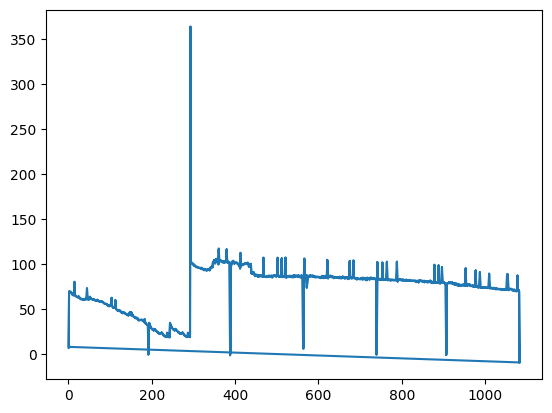

In [16]:
plt.plot( hi["cycle"], hi["hi_v"])
plt.show()


In [ ]:
for filename in os.listdir(data_dir):
    xls_file = pd.ExcelFile(f'{data_dir}/{filename}')
    sheet_fnames = [sheet for sheet in xls_file.sheet_names if sheet.startswith('Channel')]
    for sheet_fname in sheet_fnames:
        df_temp = pd.read_excel(f'{data_dir}/{filename}', sheet_name=sheet_fname)
        df_temp = df_temp[white_list]
        max_voltage = df_temp[voltage].max()
        min_voltage = df_temp[voltage].min()
        
        # df_temp = df_temp[(df_temp[voltage] >= min_voltage) & (df_temp[voltage] <= max_voltage)]
        # df_temp = df_temp[df_temp[voltage].diff().gt(0)]
        
        
        # mean_voltage = df_temp[voltage].mean()
        # std_voltage = df_temp[voltage].std()

        #Standardization
        # df_temp[voltage] = (df_temp[voltage] - mean_voltage) / std_voltage

        

        grouped_df = df_temp.groupby(df_temp[c_index])

        for key, group in grouped_df:
            t0_index = (group[voltage] >= t0_voltage).idxmax()
            t1_index = (group[voltage] >= t1_voltage).idxmax()
            #Normalization
            group[voltage] = (group[voltage] - min_voltage) / (max_voltage - min_voltage)
            # print( group[voltage] )
            # voltage_normalized = (group[voltage] - min_voltage) / (max_voltage - min_voltage)
            # hi_v = np.trapz(group[voltage])
            # hi_v = group[voltage].sum()
            hi_v = np.trapz(group[voltage].iloc[t0_index:t1_index + 1])
            # hi_v = group[voltage].iloc[t0_index:t1_index + 1].sum()
            # hi_v = 0
            # for i in range(t0_index, t1_index-1):
            #     hi_v += group[voltage].iloc[i]
            row = pd.DataFrame([{'hi_v': hi_v}])
            hi = pd.concat([hi, row])
            print("ale puzza:",max_voltage, min_voltage)


In [ ]:
print(hi)

In [ ]:
plt.plot(hi_v)

In [ ]:
hi.to_csv(f'{cleaned}/hi.csv')

In [ ]:
# #Cycle all excel files in the same folder
# for filename in os.listdir(data_dir):
#     xls_file = pd.ExcelFile(f'{data_dir}/{filename}')
#     sheet_fnames = [sheet for sheet in xls_file.sheet_names if sheet.startswith('Channel')]
    
#     df_list = []  # List to accumulate DataFrames for each sheet
    
#     for sheet_fname in sheet_fnames:
#         df_temp = pd.read_excel(f'{data_dir}/{filename}', sheet_name=sheet_fname)
#         df_temp = df_temp[[voltage, current, c_index  ]]
#         df_temp = df_temp[(df_temp[voltage] >= min_voltage) & (df_temp[voltage] <= max_voltage)]
#         df_temp = df_temp[df_temp[voltage].diff().gt(0)]
        
#         df_list.append(df_temp)  # Append the DataFrame to the list
    
#     datasets[filename] = pd.concat(df_list).to_numpy()

# # Now, concatenate the values from all datasets
# df_cycle = np.concatenate([dataset[:, 0] for dataset in datasets.values()])
# df_values = np.concatenate([np.delete(dataset, 0, axis=1) for dataset in datasets.values()])

# # Calculate mean and std
# X_mean, X_std = df_values.mean(0), df_values.std(0)

# # Normalize values
# df_values = (df_values - X_mean) / X_std

# # Min and max after normalization
# X_min, X_max = df_values.min(), df_values.max()